Notebook started March 6

Main goal: figure out how to add contiguity as a constraint/objective to PuLP

Smaller projects in service of main goal:
* dissolve county shapefile by district assignment, resulting in a new shapefile (newCDassignments) with 4 (multi)polygon entries, 1 for each district (done)
    * count how many "distinct" polygons are in each district? (no idea how?)
    * check on population/area sum values aggregated from individual counties, why they don't match pre-calculated values?
* create adjacency matrices for each district (done)
    * count connected components within each district using these (definitely possible - weird code online in various places, but maybe just brute-force with some loops, since nothing is too big?)

* figure out plotting issues - why is ____.plot() weird in main setup, etc

* main iowa_redistricting notebook: streamline a bit?



In [20]:
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
from PIL import Image, ImageOps

from pulp import (LpProblem, LpMinimize, LpVariable, lpSum, 
                  PULP_CBC_CMD, GLPK_CMD, LpStatus, value) 

##           ##this stuff is necessary for our main graphs, butscrews up the bare-bones assignment graph
from plotnine import (ggplot, aes, geom_map, geom_text, geom_label, 
                      ggtitle, element_blank, element_rect, 
                      scale_fill_manual, theme_minimal, theme)        



# import matplotlib.pyplot as plt
# plt.style.use('ggplot')
# plt.rcParams.update({'font.size': 16, 'axes.labelweight': 'bold', 'figure.figsize': (6, 6), 'axes.edgecolor': '0.2'})


# Prepping the census and geopandas dataframes

In [21]:
df=pd.read_csv('census.csv')
df.head()

,county_id,county,population,COUNTYFP10,latitude,longitude
0,0,Adair,7496,1,41.328528,-94.478164
1,1,Adams,3704,3,41.021656,-94.696906
2,2,Allamakee,14061,5,43.274964,-91.382751
3,3,Appanoose,12317,7,40.744683,-92.870345
4,4,Audubon,5674,9,41.679178,-94.904312


In [22]:
df['COUNTYFP10']=df['COUNTYFP10'].astype(str).str.pad(3,fillchar='0')

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   county_id   99 non-null     int64  
 1   county      99 non-null     object 
 2   population  99 non-null     int64  
 3   COUNTYFP10  99 non-null     object 
 4   latitude    99 non-null     float64
 5   longitude   99 non-null     float64
dtypes: float64(2), int64(2), object(2)
memory usage: 4.8+ KB


In [24]:
#imports county shapefiles from MGGG
shapefile_iowa = gpd.read_file('IA_counties/IA_counties.shp')
shapefile_iowa.head()

,STATEFP10,COUNTYFP10,GEOID10,NAME10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,TOTPOP,...,TOTVOT12,PRES12D,PRES12R,PRES12OTH,TOTVOT16,PRES16D,PRES16R,PRES16OTH,CD,geometry
0,19,127,19127,Marshall,Marshall County,1482770678,1803086,+42.0416910,-092.9814523,40648,...,19064,10257,8472,335,17980,7652,9146,1182,1,"POLYGON ((-92.76679 42.12346, -92.76679 42.122..."
1,19,011,19011,Benton,Benton County,1855117342,5760770,+42.0925474,-092.0576300,26076,...,14023,6862,6940,221,13844,4678,8232,934,1,"POLYGON ((-91.94773 41.86186, -91.95514 41.861..."
2,19,041,19041,Clay,Clay County,1469139214,13866941,+43.0798220,-095.1497261,16667,...,8502,3385,4951,166,8617,2249,5877,491,4,"POLYGON ((-95.26926 43.25537, -95.26140 43.255..."
3,19,165,19165,Shelby,Shelby County,1530110414,1486135,+41.6790143,-095.3089173,12167,...,6483,2469,3911,103,6370,1662,4362,346,4,"POLYGON ((-95.20902 41.86371, -95.20890 41.863..."
4,19,043,19043,Clayton,Clayton County,2016405612,36586071,+42.8409979,-091.3235108,18129,...,9138,4806,4164,168,9129,3237,5317,575,1,"POLYGON ((-91.25080 42.64558, -91.25160 42.645..."


# Merging pd and gpd dataframes and creating population heat map

## Prepping the data

In [25]:
map_population_by_county_data = shapefile_iowa.merge(df, on='COUNTYFP10')
county_populations = np.array(df['population'])
state_population = sum(county_populations)
df.sort_values('population', ascending=False).head()

,county_id,county,population,COUNTYFP10,latitude,longitude
76,76,Polk,492401,153,41.684281,-93.569720
56,56,Linn,230299,113,42.077951,-91.597673
81,81,Scott,174669,163,41.641679,-90.622290
51,51,Johnson,152854,103,41.668737,-91.588812
6,6,Black Hawk,131144,013,42.472888,-92.306059


# Creating the adjacency matrix for Iowa counties

In [26]:
shapefile_alpha=shapefile_iowa.sort_values('NAME10',ignore_index=True).copy()

In [27]:
shapefile_alpha.head()

,STATEFP10,COUNTYFP10,GEOID10,NAME10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,TOTPOP,...,TOTVOT12,PRES12D,PRES12R,PRES12OTH,TOTVOT16,PRES16D,PRES16R,PRES16OTH,CD,geometry
0,19,001,19001,Adair,Adair County,1474404167,2597997,+41.3285283,-094.4781643,7682,...,3996,1790,2114,92,3811,1133,2461,217,3,"POLYGON ((-94.35706 41.15745, -94.35992 41.157..."
1,19,003,19003,Adams,Adams County,1096700733,5353423,+41.0216555,-094.6969059,4029,...,2185,1028,1108,49,2106,565,1395,146,3,"POLYGON ((-94.81495 41.15839, -94.81268 41.158..."
2,19,005,19005,Allamakee,Allamakee County,1655214493,50995230,+43.2749637,-091.3827510,14330,...,6934,3553,3264,117,6923,2421,4093,409,1,"POLYGON ((-91.49104 43.50071, -91.49061 43.500..."
3,19,007,19007,Appanoose,Appanoose County,1287981483,49083877,+40.7446826,-092.8703450,12887,...,6245,2951,3161,133,6136,1814,4033,289,2,"POLYGON ((-93.09762 40.81197, -93.09761 40.812..."
4,19,009,19009,Audubon,Audubon County,1147264459,1152260,+41.6791780,-094.9043119,6119,...,3457,1611,1802,44,3412,1080,2136,196,4,"POLYGON ((-95.09316 41.68835, -95.09314 41.688..."


In [28]:
# full statewide adjacency matrix (first boolean, then casting as int)
#   NOTE: this operation counts a county as adjacent to itself. subtract eye(99) to get a more traditional version
#   also should do this operation after any sorting of the original shapefile

n_counties = 99

ia_adjac_matrix = pd.DataFrame()

for j in range(n_counties):
    ia_adjac_matrix[j] = shapefile_alpha.intersects(shapefile_alpha.iloc[[j]].unary_union)
ia_adjac_matrix = ia_adjac_matrix - np.identity(99)
ia_adjac_matrix = ia_adjac_matrix.astype(int)

ia_adjac_matrix_bool = ia_adjac_matrix.astype(bool)



# Optimization Model

## Creating decision variables, model, and objective function

In [29]:
#zeropadding county numbers for string PuLP variables
zp_county=np.array((df['county_id']).astype(str).str.pad(2,fillchar='0'))

In [30]:
n_districts = 4

ideal_district_size=state_population/n_districts

# poperrorbound: usually we've been doing 1%. I did 5%, 10%
poperrorbound = .1

district_maximum=int(ideal_district_size*(1+poperrorbound))
district_minimum=int(ideal_district_size*(1-poperrorbound))

In [31]:
# Create the linear programming model.
model = LpProblem("Supply-Demand-Problem", LpMinimize) 
variable_names = [zp_county[i]+str(j) for j in range(n_districts)
                                for i in range(n_counties)]
variable_names.sort() 

# The Decision Variable is 1 if the county is assigned to the district.
DV_variable_y = LpVariable.matrix("Y", variable_names, cat="Binary")
assignment = np.array(DV_variable_y).reshape(n_counties,n_districts)

# # The Decision Variable is the population allocated to the district.
DV_variable_x = LpVariable.matrix("X", variable_names, cat="Integer",
                                  lowBound=0)
allocation = np.array(DV_variable_x).reshape(n_counties,n_districts)

In [32]:
# This objective minimizes the counties split among multiple districts.
objective_function = lpSum(assignment) 
model += objective_function

## Initial Assignment / Allocation Constraints

In [33]:
# Allocate 100% of the population from each county.
for i in range(n_counties):
    model += lpSum(allocation[i][j] for j in range(n_districts)) == county_populations[i] , "Allocate All " + str(i)

In [34]:
print(allocation[0][1], county_populations[0])

X_001 7496


In [35]:
# This constraint makes assignment required for allocation.
# sum(county_populations) is the "big M"
for i in range(n_counties): 
    for j in range(n_districts):
        model += allocation[i][j] <= county_populations[i]*assignment[i][j] , "Allocation assignment of county" + str(i) + "to district" + str(j)
        model += allocation[i][j] >= .2*county_populations[i]*assignment[i][j], "Minimum allocation of county" + str(i) + "to" + str(j)

In [36]:
#numpy documentation for np array
#https://numpy.org/doc/stable/glossary.html#term-row-major
# Contiguous districts constraints

#n_neighbors: number of neighbors of a particular county required to be in the same district
#oregon was 1, we've tried 2/3
num_neighbors = 2
for j in range(n_districts):
    for i in range(n_counties):
        model += num_neighbors*assignment[i][j] <= lpSum(assignment[:,j][ia_adjac_matrix_bool[i]]), "Contiguity constraint for county " + str(i) +" in district " + str(j)



In [37]:
# District size constraints, in order to keep the size of districts by population similar
for j in range(n_districts):
    model += lpSum(allocation[i][j] for i in range(n_counties)) <= district_maximum , "District Size Maximum " + str(j)
    model += lpSum(allocation[i][j] for i in range(n_counties)) >= district_minimum , "District Size Minimum " + str(j)

In [38]:
# Only allow counties that meet certain critera to be split among multiple districts
# This not necessary for Iowa.
# for i in range(n_counties): 
#     if county_populations[i] <= 75000: 
#         model += lpSum(assignment[i][j] for j in range(n_districts)) <= 1  , "Unique Assignment for county " + str(i) 
#     else:
#         model += lpSum(assignment[i][j] for j in range(n_districts)) <= 2  , "Up-to-two Assignments for county " + str(i)

In [39]:
model.solve(GLPK_CMD(options=["--mipgap", "0.05", "--gomory"])) 

print('The model status is: ',LpStatus[model.status])
print('The objective value is: ', value(objective_function))

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --cpxlp /tmp/641c7991e96043c2af044532bc486284-pulp.lp -o /tmp/641c7991e96043c2af044532bc486284-pulp.sol
 --mipgap 0.05 --gomory
Reading problem data from '/tmp/641c7991e96043c2af044532bc486284-pulp.lp'...
1295 rows, 792 columns, 5520 non-zeros
792 integer variables, 396 of which are binary
3018 lines were read
GLPK Integer Optimizer 5.0
1295 rows, 792 columns, 5520 non-zeros
792 integer variables, 396 of which are binary
Preprocessing...
1295 rows, 792 columns, 5520 non-zeros
792 integer variables, 396 of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  4.924e+05  ratio =  4.924e+05
GM: min|aij| =  4.346e-01  max|aij| =  2.301e+00  ratio =  5.296e+00
EQ: min|aij| =  1.905e-01  max|aij| =  1.000e+00  ratio =  5.248e+00
2N: min|aij| =  1.250e-01  max|aij| =  1.586e+00  ratio =  1.269e+01
Constructing initial basis...
Size of triangular part is 1295
Solving LP relaxation...
GLPK Simplex Optimizer

In [40]:
# Access the results
for i in range(n_counties):
    for j in range(n_districts):
        if allocation[i][j].value() > 0:
            print('County %d assigned to district %d: ' % (i, j), allocation[i][j].value())

County 0 assigned to district 3:  7496
County 1 assigned to district 1:  3704
County 2 assigned to district 1:  14061
County 3 assigned to district 0:  12317
County 4 assigned to district 3:  5674
County 5 assigned to district 3:  25575
County 6 assigned to district 2:  131144
County 7 assigned to district 1:  26715
County 8 assigned to district 2:  24988
County 9 assigned to district 2:  20565
County 10 assigned to district 3:  20823
County 11 assigned to district 0:  14334
County 12 assigned to district 0:  9927
County 13 assigned to district 3:  20760
County 14 assigned to district 1:  13127
County 15 assigned to district 1:  18505
County 16 assigned to district 2:  43127
County 17 assigned to district 3:  11658
County 18 assigned to district 3:  12012
County 19 assigned to district 1:  9748
County 20 assigned to district 3:  16384
County 21 assigned to district 1:  17043
County 22 assigned to district 3:  46460
County 23 assigned to district 1:  16525
County 24 assigned to district

# Visualizing the districts

## Prepping the data for visualization

In [41]:
# Prepare data for visualizing the results
result_value = []
for i in range(n_counties):
    for j in range(n_districts):
        var_output = {
            'County': i,
            'District': j+1,
            'Assignment': int(assignment[i][j].value()*(j+1)),
            'Allocation': allocation[i][j].value()}
        result_value.append(var_output)
        
results = pd.DataFrame(result_value)
results = results[results['Assignment'] != 0]
results = results.sort_values(['County', 'District'])


In [42]:
results

,County,District,Assignment,Allocation
3,0,4,4,7496
5,1,2,2,3704
9,2,2,2,14061
12,3,1,1,12317
19,4,4,4,5674
...,...,...,...,...
379,94,4,4,10679
383,95,4,4,20070
385,96,2,2,105941
391,97,4,4,7443


In [43]:
df.head()

,county_id,county,population,COUNTYFP10,latitude,longitude
0,0,Adair,7496,001,41.328528,-94.478164
1,1,Adams,3704,003,41.021656,-94.696906
2,2,Allamakee,14061,005,43.274964,-91.382751
3,3,Appanoose,12317,007,40.744683,-92.870345
4,4,Audubon,5674,009,41.679178,-94.904312


In [44]:
results = results.merge(df, left_on='County', right_on='county_id',suffixes=('_ID', '_Name'))


In [45]:
results

,County,District,Assignment,Allocation,county_id,county,population,COUNTYFP10,latitude,longitude
0,0,4,4,7496,0,Adair,7496,001,41.328528,-94.478164
1,1,2,2,3704,1,Adams,3704,003,41.021656,-94.696906
2,2,2,2,14061,2,Allamakee,14061,005,43.274964,-91.382751
3,3,1,1,12317,3,Appanoose,12317,007,40.744683,-92.870345
4,4,4,4,5674,4,Audubon,5674,009,41.679178,-94.904312
...,...,...,...,...,...,...,...,...,...,...
94,94,4,4,10679,94,Winnebago,10679,189,43.378124,-93.743488
95,95,4,4,20070,95,Winneshiek,20070,191,43.292989,-91.850788
96,96,2,2,105941,96,Woodbury,105941,193,42.393220,-96.053296
97,97,4,4,7443,97,Worth,7443,195,43.373491,-93.248533


In [46]:
data=results.drop(columns=['County', 'population']).copy()

In [47]:
data

,District,Assignment,Allocation,county_id,county,COUNTYFP10,latitude,longitude
0,4,4,7496,0,Adair,001,41.328528,-94.478164
1,2,2,3704,1,Adams,003,41.021656,-94.696906
2,2,2,14061,2,Allamakee,005,43.274964,-91.382751
3,1,1,12317,3,Appanoose,007,40.744683,-92.870345
4,4,4,5674,4,Audubon,009,41.679178,-94.904312
...,...,...,...,...,...,...,...,...
94,4,4,10679,94,Winnebago,189,43.378124,-93.743488
95,4,4,20070,95,Winneshiek,191,43.292989,-91.850788
96,2,2,105941,96,Woodbury,193,42.393220,-96.053296
97,4,4,7443,97,Worth,195,43.373491,-93.248533


In [48]:
# results['Multiple_County_Name'] = results['County_Name'].shift(periods=1)
# results['Multiple_District'] = results['District'].shift(periods=1).fillna(99).astype(int)

# Edit the assignment for the case when a county has multiple assignments 
# for i in range(0,len(results)):
#     if results['County_Name'].loc[i] == results['Multiple_County_Name'].loc[i]:
#         results.loc[i, 'Assignment'] =   int(str(results['District'].loc[i]) + \
#                                                         str(results['Multiple_District'].loc[i]))
# results = results.sort_values(['District','County_Name'])
# results.index = results['County_ID']

## Creating the maps

In [49]:
color_dict = { 1 : 'red',
               2 : 'green',
               3 : 'pink',
               4 : 'blue',
               }

def iowa_map(map_data):
    """
    Create three maps to visualize the results.  
    (1) A map with county IDs labels
    (2) A map with county labels
    """
    plot_map_population_labels = (
        ggplot(map_data)
    + geom_map(aes(fill=str('Assignment'))) 
    + geom_label(aes(x='longitude', y='latitude', label='county_id',size=2), show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            figure_size=(7, 4))
    + scale_fill_manual(values=color_dict))
    
    plot_map_county_labels = (
        ggplot(map_data)
    + geom_map(aes(fill=str('Assignment'))) 
    + geom_label(aes(x='longitude', y='latitude', label='county', size=2), 
                 show_legend=False)
    + theme_minimal()
    + theme(axis_text_x=element_blank(),
            axis_text_y=element_blank(),
            axis_title_x=element_blank(),
            axis_title_y=element_blank(),
            axis_ticks=element_blank(),
            panel_grid_major=element_blank(),
            panel_grid_minor=element_blank(),
            figure_size=(7, 4))
    + scale_fill_manual(values=color_dict))
    
    # plot_map_county_ids = (
    #     ggplot(map_data)
    # + geom_map(aes(fill=str('Assignment'))) 
    # + geom_label(aes(x='longitude', y='latitude', label='population', size=5), 
    #              show_legend=False)
    # + theme_minimal()
    # + theme(axis_text_x=element_blank(),
    #         axis_text_y=element_blank(),
    #         axis_title_x=element_blank(),
    #         axis_title_y=element_blank(),
    #         axis_ticks=element_blank(),
    #         panel_grid_major=element_blank(),
    #         panel_grid_minor=element_blank(),
    #         figure_size=(7, 4))
    # + scale_fill_manual(values=color_dict))
    
    return plot_map_population_labels, plot_map_county_labels
# , plot_map_county_ids


In [50]:
shapefile_iowa.head(2)

,STATEFP10,COUNTYFP10,GEOID10,NAME10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,TOTPOP,...,TOTVOT12,PRES12D,PRES12R,PRES12OTH,TOTVOT16,PRES16D,PRES16R,PRES16OTH,CD,geometry
0,19,127,19127,Marshall,Marshall County,1482770678,1803086,+42.0416910,-092.9814523,40648,...,19064,10257,8472,335,17980,7652,9146,1182,1,"POLYGON ((-92.76679 42.12346, -92.76679 42.122..."
1,19,011,19011,Benton,Benton County,1855117342,5760770,+42.0925474,-092.0576300,26076,...,14023,6862,6940,221,13844,4678,8232,934,1,"POLYGON ((-91.94773 41.86186, -91.95514 41.861..."


In [51]:
results.head(2)

,County,District,Assignment,Allocation,county_id,county,population,COUNTYFP10,latitude,longitude
0,0,4,4,7496,0,Adair,7496,001,41.328528,-94.478164
1,1,2,2,3704,1,Adams,3704,003,41.021656,-94.696906


In [52]:
df.head(2)

,county_id,county,population,COUNTYFP10,latitude,longitude
0,0,Adair,7496,001,41.328528,-94.478164
1,1,Adams,3704,003,41.021656,-94.696906


In [53]:
map_first_pass = shapefile_iowa.merge(data, left_on='COUNTYFP10', right_on='COUNTYFP10')
# map_first_pass['District'] = map_first_pass['District']+1



In [54]:
map_first_pass.head()

,STATEFP10,COUNTYFP10,GEOID10,NAME10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,TOTPOP,...,PRES16OTH,CD,geometry,District,Assignment,Allocation,county_id,county,latitude,longitude
0,19,127,19127,Marshall,Marshall County,1482770678,1803086,+42.0416910,-092.9814523,40648,...,1182,1,"POLYGON ((-92.76679 42.12346, -92.76679 42.122...",1,1,40105,63,Marshall,42.041691,-92.981452
1,19,011,19011,Benton,Benton County,1855117342,5760770,+42.0925474,-092.0576300,26076,...,934,1,"POLYGON ((-91.94773 41.86186, -91.95514 41.861...",4,4,25575,5,Benton,42.092547,-92.057630
2,19,041,19041,Clay,Clay County,1469139214,13866941,+43.0798220,-095.1497261,16667,...,491,4,"POLYGON ((-95.26926 43.25537, -95.26140 43.255...",4,4,16384,20,Clay,43.079822,-95.149726
3,19,165,19165,Shelby,Shelby County,1530110414,1486135,+41.6790143,-095.3089173,12167,...,346,4,"POLYGON ((-95.20902 41.86371, -95.20890 41.863...",4,4,11746,82,Shelby,41.679014,-95.308917
4,19,043,19043,Clayton,Clayton County,2016405612,36586071,+42.8409979,-091.3235108,18129,...,575,1,"POLYGON ((-91.25080 42.64558, -91.25160 42.645...",2,2,17043,21,Clayton,42.840998,-91.323511


In [55]:
# map_first_pass['District'] = map_first_pass['District'].astype('category')
map_first_pass['Assignment'] = map_first_pass['Assignment'].astype("category")


In [56]:
data.loc[data['Assignment']==1]

,District,Assignment,Allocation,county_id,county,COUNTYFP10,latitude,longitude
3,1,1,12317,3,Appanoose,007,40.744683,-92.870345
11,1,1,14334,11,Butler,023,42.734708,-92.780066
12,1,1,9927,12,Calhoun,025,42.386170,-94.643683
24,1,1,99678,24,Dallas,049,41.685321,-94.040706
37,1,1,12329,37,Grundy,075,42.403323,-92.790261
41,1,1,16878,41,Hardin,083,42.389955,-93.241081
58,1,1,8634,58,Lucas,117,41.033344,-93.331467
59,1,1,11934,59,Lyon,119,43.383580,-96.207201
60,1,1,16548,60,Madison,121,41.330622,-94.015184
63,1,1,40105,63,Marshall,127,42.041691,-92.981452


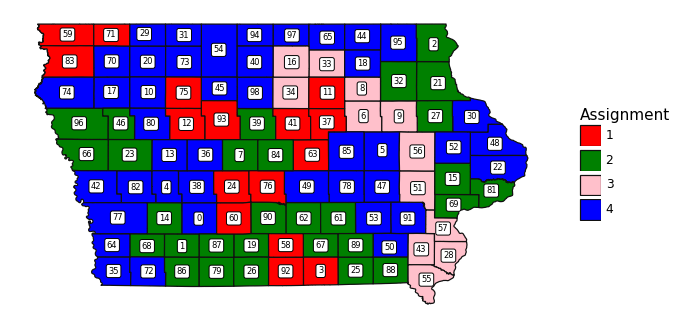

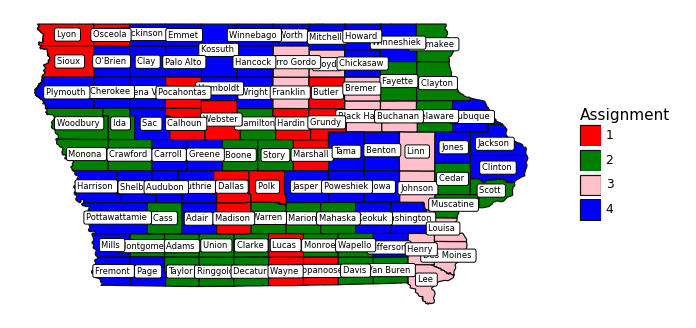

(<ggplot: (8741981565977)>, <ggplot: (8741981376943)>)

In [58]:
iowa_map(map_first_pass)

In [59]:
district_totals = pd.DataFrame(results.groupby('District')['Allocation'].sum().astype('int64'))
district_totals

,Allocation
District,
1,827723
2,817608
3,732407
4,812631


## making polygons based on assignments

In [60]:
map_first_pass.head()

,STATEFP10,COUNTYFP10,GEOID10,NAME10,NAMELSAD10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,TOTPOP,...,PRES16OTH,CD,geometry,District,Assignment,Allocation,county_id,county,latitude,longitude
0,19,127,19127,Marshall,Marshall County,1482770678,1803086,+42.0416910,-092.9814523,40648,...,1182,1,"POLYGON ((-92.76679 42.12346, -92.76679 42.122...",1,1,40105,63,Marshall,42.041691,-92.981452
1,19,011,19011,Benton,Benton County,1855117342,5760770,+42.0925474,-092.0576300,26076,...,934,1,"POLYGON ((-91.94773 41.86186, -91.95514 41.861...",4,4,25575,5,Benton,42.092547,-92.057630
2,19,041,19041,Clay,Clay County,1469139214,13866941,+43.0798220,-095.1497261,16667,...,491,4,"POLYGON ((-95.26926 43.25537, -95.26140 43.255...",4,4,16384,20,Clay,43.079822,-95.149726
3,19,165,19165,Shelby,Shelby County,1530110414,1486135,+41.6790143,-095.3089173,12167,...,346,4,"POLYGON ((-95.20902 41.86371, -95.20890 41.863...",4,4,11746,82,Shelby,41.679014,-95.308917
4,19,043,19043,Clayton,Clayton County,2016405612,36586071,+42.8409979,-091.3235108,18129,...,575,1,"POLYGON ((-91.25080 42.64558, -91.25160 42.645...",2,2,17043,21,Clayton,42.840998,-91.323511


In [61]:
list(map_first_pass.columns)

['STATEFP10',
 'COUNTYFP10',
 'GEOID10',
 'NAME10',
 'NAMELSAD10',
 'ALAND10',
 'AWATER10',
 'INTPTLAT10',
 'INTPTLON10',
 'TOTPOP',
 'NH_WHITE',
 'NH_BLACK',
 'NH_AMIN',
 'NH_ASIAN',
 'NH_NHPI',
 'NH_OTHER',
 'NH_2MORE',
 'HISP',
 'H_WHITE',
 'H_BLACK',
 'H_AMIN',
 'H_ASIAN',
 'N_NHPI',
 'H_OTHER',
 'H_2MORE',
 'VAP',
 'HVAP',
 'WVAP',
 'BVAP',
 'AMINVAP',
 'ASIANVAP',
 'NHPIVAP',
 'OTHERVAP',
 '2MOREVAP',
 'TOTVOT00',
 'PRES00D',
 'PRES00R',
 'PRES00G',
 'PRES00OTH',
 'TOTVOT04',
 'PRES04D',
 'PRES04R',
 'PRES04OTH',
 'TOTVOT08',
 'PRES08D',
 'PRES08R',
 'PRES08OTH',
 'TOTVOT12',
 'PRES12D',
 'PRES12R',
 'PRES12OTH',
 'TOTVOT16',
 'PRES16D',
 'PRES16R',
 'PRES16OTH',
 'CD',
 'geometry',
 'District',
 'Assignment',
 'Allocation',
 'county_id',
 'county',
 'latitude',
 'longitude']

In [62]:
## this does NOT include FIPS or indices...
columns_to_sum=[
 'NAME10',
 'ALAND10',
 'AWATER10',
 'TOTPOP',
 'NH_WHITE',
 'NH_BLACK',
 'NH_AMIN',
 'NH_ASIAN',
 'NH_NHPI',
 'NH_OTHER',
 'NH_2MORE',
 'HISP',
 'H_WHITE',
 'H_BLACK',
 'H_AMIN',
 'H_ASIAN',
 'N_NHPI',
 'H_OTHER',
 'H_2MORE',
 'VAP',
 'HVAP',
 'WVAP',
 'BVAP',
 'AMINVAP',
 'ASIANVAP',
 'NHPIVAP',
 'OTHERVAP',
 '2MOREVAP',
 'TOTVOT00',
 'PRES00D',
 'PRES00R',
 'PRES00G',
 'PRES00OTH',
 'TOTVOT04',
 'PRES04D',
 'PRES04R',
 'PRES04OTH',
 'TOTVOT08',
 'PRES08D',
 'PRES08R',
 'PRES08OTH',
 'TOTVOT12',
 'PRES12D',
 'PRES12R',
 'PRES12OTH',
 'TOTVOT16',
 'PRES16D',
 'PRES16R',
 'PRES16OTH',
 'geometry',
 'Assignment',
 'Allocation']

In [63]:
newCDassignments_temp = map_first_pass[columns_to_sum]

In [65]:
#dissolve the shapefile/merge counties. group by "Assignment column". Aggregate regions which are combining by summing the totals in numeric columns (population, area, etc)
newCDassignments = newCDassignments_temp.dissolve(
    by="Assignment",
    aggfunc = 'sum'
)

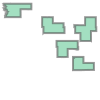

In [66]:
newCDassignments['geometry'][1]

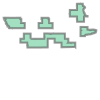

In [67]:
newCDassignments['geometry'][2]

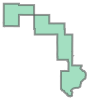

In [68]:
newCDassignments['geometry'][3]

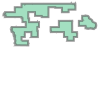

In [69]:
newCDassignments['geometry'][4]

In [ ]:
# # this prints the whole multipolygon/all corners....
# print(newCDassignments['geometry'][1])


# suuuuper complicated even for a single county
# print(shapefile_iowa['geometry'][1])

In [73]:
newCDassignments.head()

,geometry,ALAND10,AWATER10,TOTPOP,NH_WHITE,NH_BLACK,NH_AMIN,NH_ASIAN,NH_NHPI,NH_OTHER,...,PRES08OTH,TOTVOT12,PRES12D,PRES12R,PRES12OTH,TOTVOT16,PRES16D,PRES16R,PRES16OTH,Allocation
Assignment,,,,,,,,,,,,,,,,,,,,,
1,"MULTIPOLYGON (((-93.55677 40.63848, -93.55671 ...",23356151751,148991968,732884,622003,28862,1410,18123,339,744,...,6195,385958,193489,185554,6915,387009,168845,189752,28412,827723
2,"MULTIPOLYGON (((-95.20902 41.86371, -95.20906 ...",41452457966,321065072,796975,701381,18952,3181,13703,383,523,...,6787,401047,204796,188604,7647,398093,155840,213148,29105,817608
3,"MULTIPOLYGON (((-90.94938 41.07271, -90.94932 ...",16378666187,235008123,697285,613125,30421,1261,14131,452,594,...,5843,376680,221518,148209,6953,367892,184207,155967,27718,732407
4,"MULTIPOLYGON (((-90.67005 41.76363, -90.67007 ...",62595897388,371529842,819211,764614,8671,2729,6640,623,271,...,6676,418495,202741,208250,7504,413037,144777,242116,26144,812631


In [74]:
# make "assignment" a regular column again, instead of the index
newCDassignments=newCDassignments.reset_index().copy()

In [75]:
######## wtf????? why doesn't this work...............

# ggplot(newCDassignments)
# + geom_map(aes(fill=str('Assignment'))) 

TypeError: bad operand type for unary +: 'geom_map'

In [76]:
newCDassignments.plot(column="Assignment",edgecolor="0.2",figsize=(10,8))

<AxesSubplot:>

<AxesSubplot:>

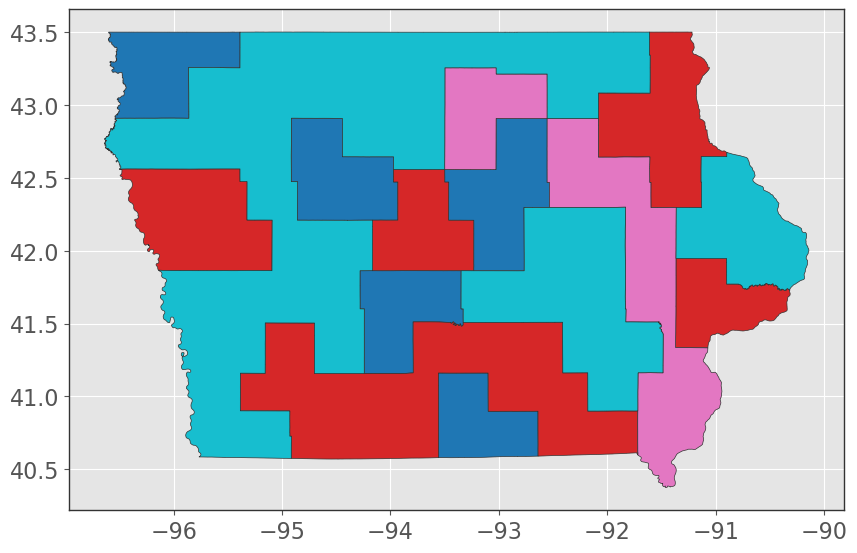

In [ ]:
#won't work with the way ggplot has been imported in main bit; will just be blank
newCDassignments.plot(column="Assignment",edgecolor="0.2",figsize=(10,8))

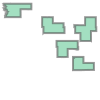

In [79]:
newCDassignments.at[0,"geometry"]

In [80]:
newCDassignments.at[2, 'geometry'].area

1.807348344903498

# Making new adjacency matrices for districts

In [81]:
ia_adjac_matrix.loc[0:9,0:9]

,0,1,2,3,4,5,6,7,8,9
0,0,1,0,0,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,0,1
6,0,0,0,0,0,1,0,0,1,1
7,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,1,0,0,1
9,0,0,0,0,0,1,1,0,1,0


In [82]:
ia_adjac_matrix.loc[[0,1,3],[0,1,3]]

,0,1,3
0,0,1,0
1,1,0,0
3,0,0,0


In [83]:
# adjacency matrix for counties assigned to district 1
district1adj = ia_adjac_matrix.loc[data['Assignment']==1,data['Assignment']==1]
district2adj = ia_adjac_matrix.loc[data['Assignment']==2,data['Assignment']==2]
district3adj = ia_adjac_matrix.loc[data['Assignment']==3,data['Assignment']==3]
district4adj = ia_adjac_matrix.loc[data['Assignment']==4,data['Assignment']==4]


In [88]:
district3adj

,6,8,9,16,28,33,34,43,51,55,56,57
6,0,1,1,0,0,0,0,0,0,0,0,0
8,1,0,1,0,0,1,0,0,0,0,0,0
9,1,1,0,0,0,0,0,0,0,0,1,0
16,0,0,0,0,0,1,1,0,0,0,0,0
28,0,0,0,0,0,0,0,1,0,1,0,1
33,0,1,0,1,0,0,1,0,0,0,0,0
34,0,0,0,1,0,1,0,0,0,0,0,0
43,0,0,0,0,1,0,0,0,0,1,0,1
51,0,0,0,0,0,0,0,0,0,0,1,1
55,0,0,0,0,1,0,0,1,0,0,0,0


In [89]:
#counties per district: 16, 29, 12, 42
16+29+12+42

99